Device in use: cpu


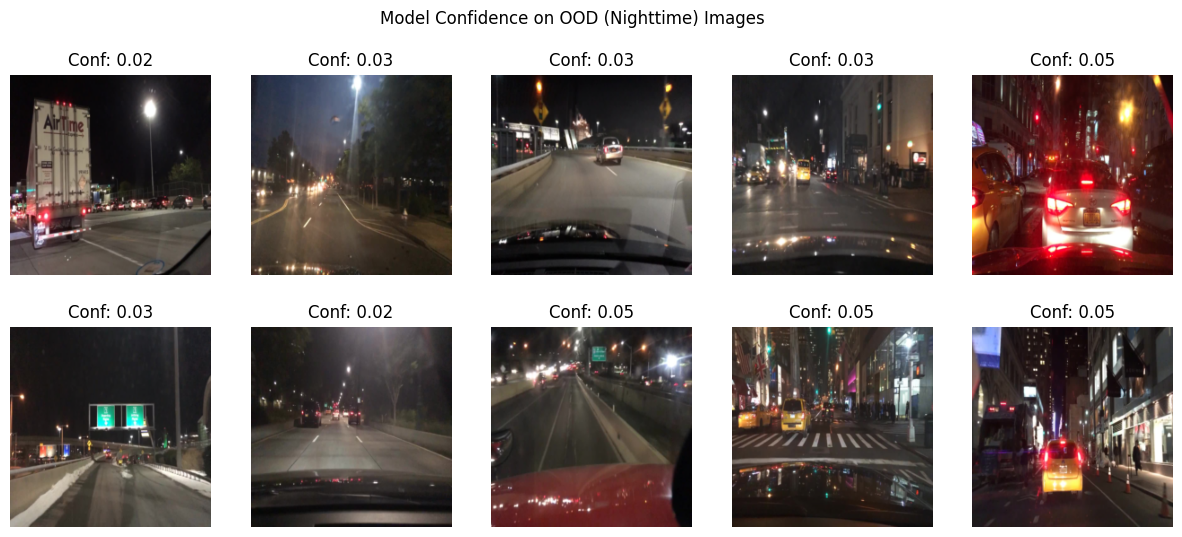

In [1]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)

# Load model and trained weights
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load("../models/resnet18_id_only.pth", map_location=device))
model = model.to(device)
model.eval()

# Transform for test images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load OOD dataset (nighttime)
ood_dataset = datasets.ImageFolder(root=r"D:\ODD PROJECT\DATA\BDD\scene_classification\ood", transform=transform)
ood_loader = DataLoader(ood_dataset, batch_size=1, shuffle=True)

# Predict and collect confidence scores
softmax = nn.Sigmoid()
results = []

with torch.no_grad():
    for i, (img, _) in enumerate(ood_loader):
        img = img.to(device)
        output = model(img)
        score = softmax(output).item()
        results.append((img.cpu(), score))
        if i >= 9:  # Limit to 10 samples for display
            break

# Plot 10 predictions with softmax scores
plt.figure(figsize=(15, 6))
for i, (img, score) in enumerate(results):
    img_np = img.squeeze(0).permute(1, 2, 0).numpy()
    img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Unnormalize
    img_np = np.clip(img_np, 0, 1)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img_np)
    plt.title(f"Conf: {score:.2f}")
    plt.axis("off")

plt.suptitle("Model Confidence on OOD (Nighttime) Images")
plt.show()
